<a href="https://colab.research.google.com/github/Angi03/time_series/blob/main/4_Vector_Auto_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VECTOR AUTO REGRESSION EQUATION:**

The dynamics of complex phenomena in economics and finance can rarely
be described using a single time series. That's why, we will turn to multidimensional time series, but it should always be
borne in mind that many time series change synchronously in a certain interdependence. Therefore, now we will move on to approaches
and methods of joint modeling of two or more time series.

Vector autoregression (VAR) is a model of the dynamics of several time series in which the current values of these series depend on the past values of the same time series. The model is proposed by Christopher Sims as an alternative to systems of simultaneous equations that assume significant theoretical limitations. VAR models are free from the constraints of structural models. Nevertheless, the problem of VAR models is a sharp increase in the number of parameters with an increase in the number of analyzed time series and the number of lags.

The simplest example is a two-dimensional vector autoregressive model

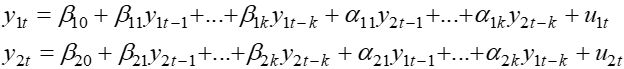

where uit are independent and equally distributed error terms with E(uit)=0, i=1,2; E(u1t u2t)=0.

The analysis can be extended to the VAR(g) model or so that there are g variables and g equations.

In [ ]:
#Importing Libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from datetime import datetime
import yfinance as yf

**Parsing from yahoo finance**

In [ ]:
tickers_list = ['GC=F', 'SI=F', 'CL=F']
yf.download(tickers_list)
data = pd.DataFrame(columns = tickers_list)
for ticker in tickers_list:
    data[ticker] = yf.download(ticker, start = '2007-01-01')['Adj Close']
data

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,GC=F,SI=F,CL=F
Date,,,
2007-01-02,635.200012,12.818000,61.049999
2007-01-03,627.099976,12.555000,58.320000
2007-01-04,623.900024,12.727000,55.590000
2007-01-05,604.900024,12.130000,56.310001
2007-01-08,607.500000,12.260000,56.090000
...,...,...,...
2024-04-04,2288.800049,27.139999,86.589996
2024-04-05,2325.699951,27.400000,86.910004
2024-04-08,2331.699951,27.712000,86.430000


In [ ]:
data.isnull().sum() #missing values

GC=F    0
SI=F    1
CL=F    0
dtype: int64

In [ ]:
data=data.fillna(method='pad') #filling the missing values with previous one
data.isnull().sum()

GC=F    0
SI=F    0
CL=F    0
dtype: int64

In [ ]:
data

,GC=F,SI=F,CL=F
Date,,,
2007-01-02,635.200012,12.818000,61.049999
2007-01-03,627.099976,12.555000,58.320000
2007-01-04,623.900024,12.727000,55.590000
2007-01-05,604.900024,12.130000,56.310001
2007-01-08,607.500000,12.260000,56.090000
...,...,...,...
2024-04-04,2288.800049,27.139999,86.589996
2024-04-05,2325.699951,27.400000,86.910004
2024-04-08,2331.699951,27.712000,86.430000


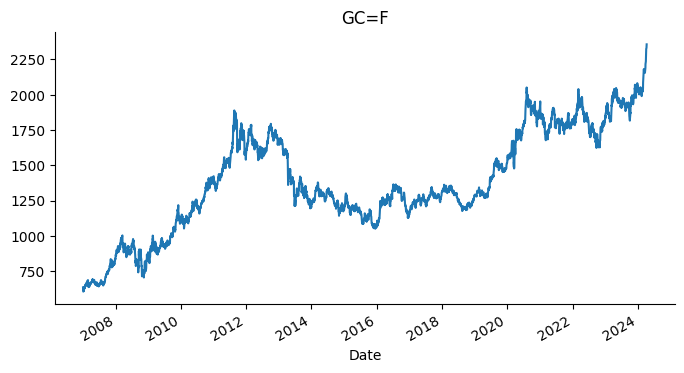

In [ ]:
# @title GC=F

from matplotlib import pyplot as plt
data['GC=F'].plot(kind='line', figsize=(8, 4), title='GC=F')
plt.gca().spines[['top', 'right']].set_visible(False)

The NaN values in the data are filled with previous days data. After doing some necessary pre-processing, the dataset now clean for further analysis.

**Plot of historical data**

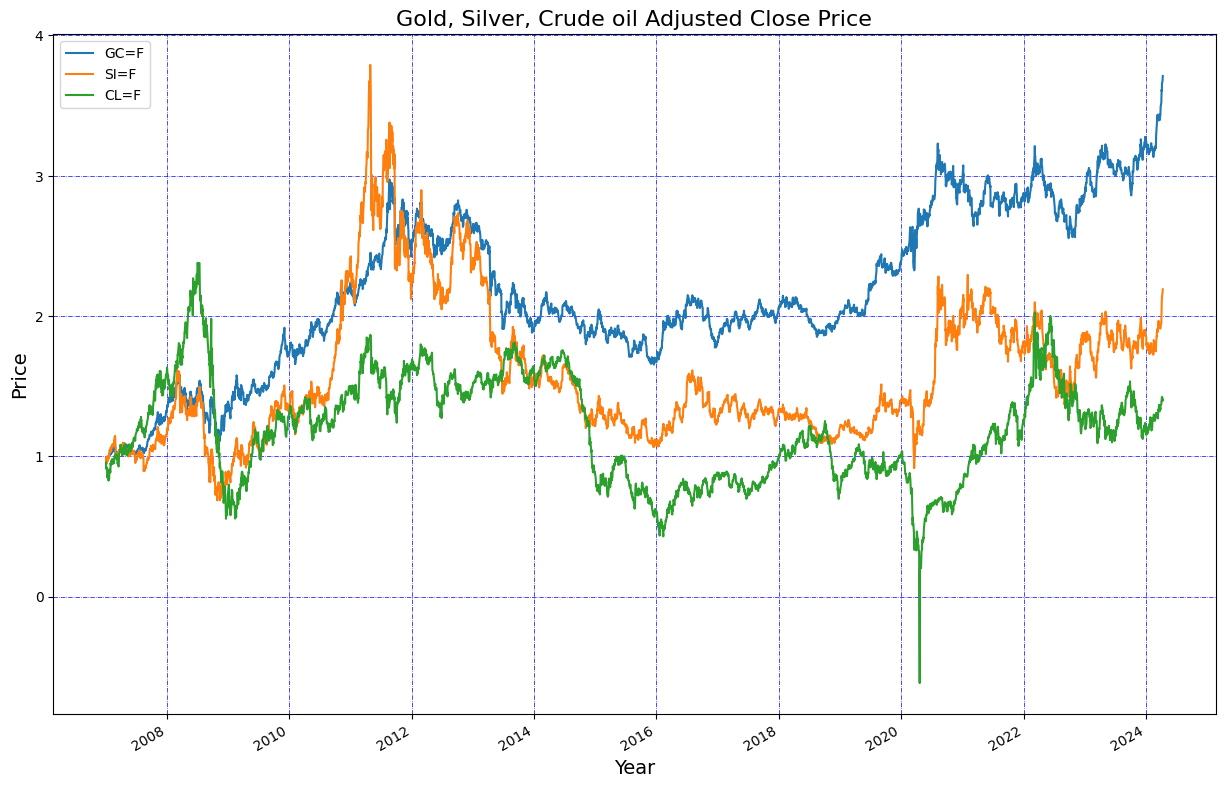

In [ ]:
# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(15, 10))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Gold, Silver, Crude oil Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='b', linestyle='-.', linewidth=0.5)
#plt.savefig('Green_Adj_Close_Price.png')
plt.show()

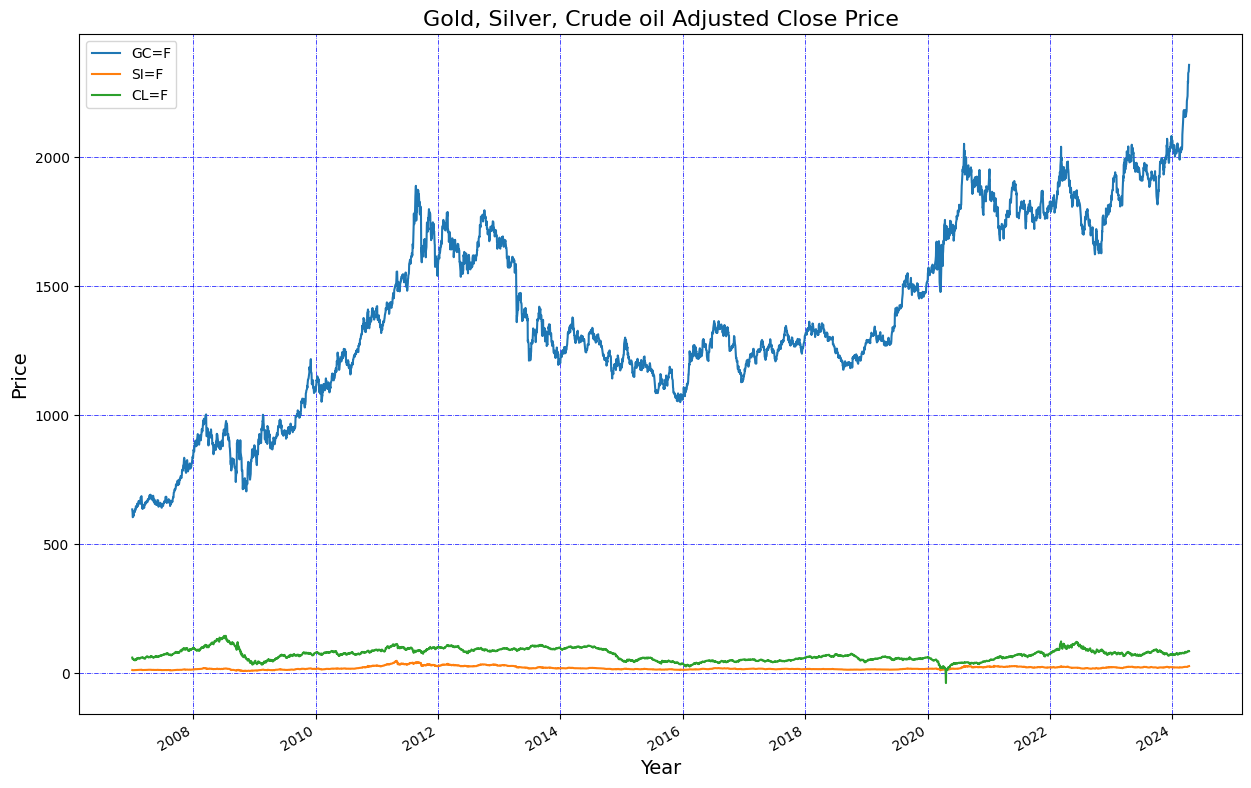

In [ ]:
# Plot all the close prices
data.plot(figsize=(15, 10))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Gold, Silver, Crude oil Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='b', linestyle='-.', linewidth=0.5)
#plt.savefig('Green_Adj_Close_Price.png')
plt.show()

**Converting data to log return**

In [ ]:
log_returns = np.log(data)-np.log(data.shift(1))
log_returns = log_returns.round(3)
log_returns = log_returns.dropna()

In [ ]:
log_returns

,GC=F,SI=F,CL=F
Date,,,
2007-01-03,-0.013,-0.021,-0.046
2007-01-04,-0.005,0.014,-0.048
2007-01-05,-0.031,-0.048,0.013
2007-01-08,0.004,0.011,-0.004
2007-01-09,0.009,0.019,-0.008
...,...,...,...
2024-04-04,-0.002,0.007,0.013
2024-04-05,0.016,0.010,0.004
2024-04-08,0.003,0.011,-0.006


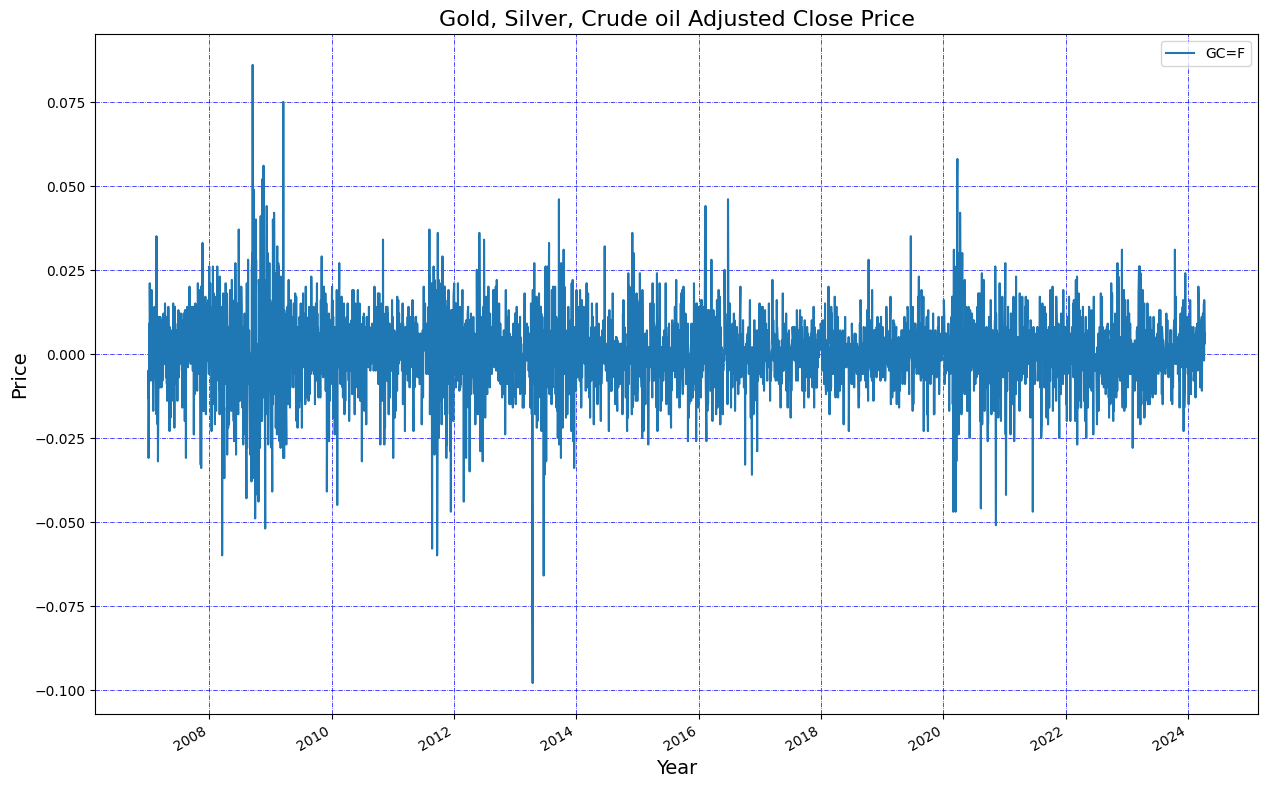

In [ ]:
# Plot all the close prices
log_returns['GC=F'].plot(figsize=(15, 10))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Gold, Silver, Crude oil Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='b', linestyle='-.', linewidth=0.5)
#plt.savefig('Green_Adj_Close_Price.png')
plt.show()

In [ ]:
log_returns.isnull().sum()

GC=F    0
SI=F    0
CL=F    0
dtype: int64

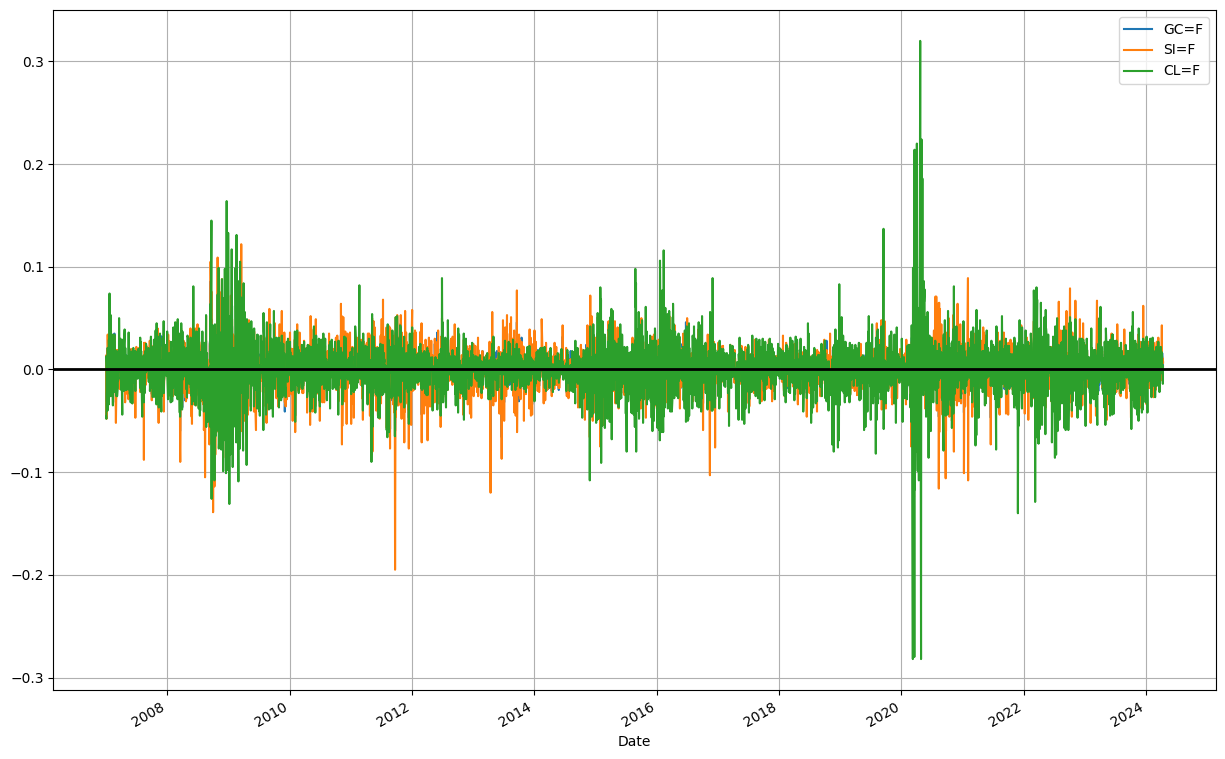

In [ ]:
log_returns.plot(grid = True, figsize = (15,10)).axhline(y = 0, color = "black", lw = 2)

**Augmented Dickey-Fuller Test**

A time series is said to be “stationary” if it has no trend, exhibits constant variance over time, and has a constant autocorrelation structure over time.

One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [ ]:
ad_fuller_result_1 = adfuller(log_returns['GC=F'])

print('Gold')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(log_returns['SI=F'])

print('Silver')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(log_returns['CL=F'])

print('Crude Oil')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

Gold
ADF Statistic: -20.86531104717892
p-value: 0.0

---------------------

Silver
ADF Statistic: -33.5418477693166
p-value: 0.0

---------------------

Crude Oil
ADF Statistic: -11.511039231792676
p-value: 4.259278714084955e-21


A difference transform is a simple way for removing a systematic structure from the time series. We will remove trend by subtracting the previous value from each value in the series which is the first order differencing. To keep it simple, we will do first order differencing or seasonal differencing.

In [ ]:
ad_fuller_result_1 = adfuller(data['GC=F'].diff(1).dropna())

print('Gold')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(data['SI=F'].diff(1).dropna())

print('Silver')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(data['CL=F'].diff(1).dropna())

print('Crude Oil')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

Gold
ADF Statistic: -21.773710247055654
p-value: 0.0

---------------------

Silver
ADF Statistic: -13.026695815857707
p-value: 2.3913922008457494e-24

---------------------

Crude Oil
ADF Statistic: -10.61989063062753
p-value: 5.550350666730267e-19


**Granger Causality test**

The Granger Causality test is used to determine whether or not one time series is useful for forecasting another.

This test uses the following null and alternative hypotheses:

Null Hypothesis (H0): Time series x does not Granger-cause time series y

Alternative Hypothesis (HA): Time series x Granger-causes time series y

The term “Granger-causes” means that knowing the value of time series x at a certain lag is useful for predicting the value of time series y at a later time period.

This test produces an F test statistic with a corresponding p-value. If the p-value is less than a certain significance level (i.e. α = .05), then we can reject the null hypothesis and conclude that we have sufficient evidence to say that time series x Granger-causes time series y.

In [ ]:
print('gold causes crude oil?\n')
print('------------------')
granger_1 = grangercausalitytests(log_returns[['GC=F', 'CL=F']], 4)

print('\ncrude oil causes gold?\n')
print('------------------')
granger_2 = grangercausalitytests(log_returns[['CL=F', 'GC=F']], 4)

gold causes crude oil?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0298  , p=0.3103  , df_denom=4339, df_num=1
ssr based chi2 test:   chi2=1.0305  , p=0.3100  , df=1
likelihood ratio test: chi2=1.0304  , p=0.3101  , df=1
parameter F test:         F=1.0298  , p=0.3103  , df_denom=4339, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7304  , p=0.4818  , df_denom=4336, df_num=2
ssr based chi2 test:   chi2=1.4626  , p=0.4813  , df=2
likelihood ratio test: chi2=1.4623  , p=0.4814  , df=2
parameter F test:         F=0.7304  , p=0.4818  , df_denom=4336, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5760  , p=0.6307  , df_denom=4333, df_num=3
ssr based chi2 test:   chi2=1.7308  , p=0.6301  , df=3
likelihood ratio test: chi2=1.7305  , p=0.6302  , df=3
parameter F test:         F=0.5760  , p=0.6307  , df_denom=4333, df_num=3

Granger Causality
number of lags (no zero) 4

In [ ]:
print('gold causes crude oil?\n')
print('------------------')
granger_1 = grangercausalitytests(log_returns[['GC=F', 'CL=F']], 4)

print('\ncrude oil causes gold?\n')
print('------------------')
granger_2 = grangercausalitytests(log_returns[['CL=F', 'GC=F']], 4)

gold causes crude oil?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0298  , p=0.3103  , df_denom=4339, df_num=1
ssr based chi2 test:   chi2=1.0305  , p=0.3100  , df=1
likelihood ratio test: chi2=1.0304  , p=0.3101  , df=1
parameter F test:         F=1.0298  , p=0.3103  , df_denom=4339, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7304  , p=0.4818  , df_denom=4336, df_num=2
ssr based chi2 test:   chi2=1.4626  , p=0.4813  , df=2
likelihood ratio test: chi2=1.4623  , p=0.4814  , df=2
parameter F test:         F=0.7304  , p=0.4818  , df_denom=4336, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5760  , p=0.6307  , df_denom=4333, df_num=3
ssr based chi2 test:   chi2=1.7308  , p=0.6301  , df=3
likelihood ratio test: chi2=1.7305  , p=0.6302  , df=3
parameter F test:         F=0.5760  , p=0.6307  , df_denom=4333, df_num=3

Granger Causality
number of lags (no zero) 4

In [ ]:
data

,GC=F,SI=F,CL=F
Date,,,
2007-01-02,635.200012,12.818000,61.049999
2007-01-03,627.099976,12.555000,58.320000
2007-01-04,623.900024,12.727000,55.590000
2007-01-05,604.900024,12.130000,56.310001
2007-01-08,607.500000,12.260000,56.090000
...,...,...,...
2024-04-04,2288.800049,27.139999,86.589996
2024-04-05,2325.699951,27.400000,86.910004
2024-04-08,2331.699951,27.712000,86.430000


In [ ]:
#Splitting the dataset
train_df=data[:-1200]
test_df=data[-1200:]

print(train_df.shape)
print(test_df.shape)

(3146, 3)
(1200, 3)


In [ ]:
model = VAR(train_df.diff()[1:])

In [ ]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

In [ ]:
print(model.select_order(20))

In [ ]:
results = model.fit(16)
results.summary()

In [ ]:
results.plot_acorr()

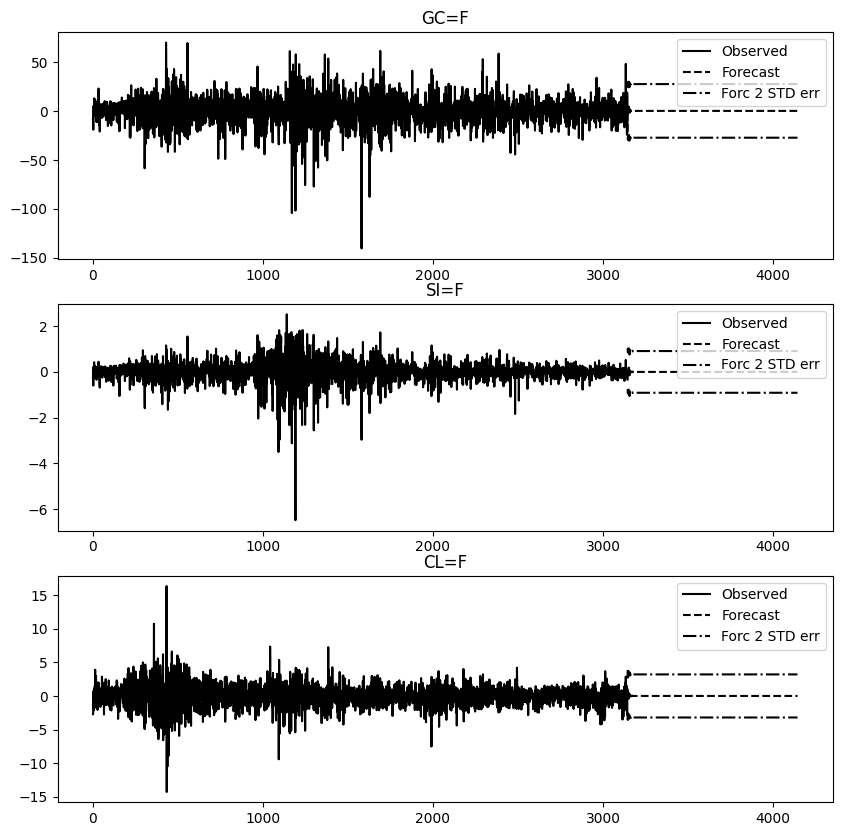

In [ ]:
results.plot_forecast(1000)
plt.show()

# **Impulse Response Function**

An impulse response can be defined as the reaction of a system, in response to an external change. In the macroeconomic context, the system is a system of equations that comprise a multivariate autoregressive model, and the external change is referred to as an exogenous shock. All the variables in a VAR model depend on each other; therefore, individual coefficient estimates provide limited information on the reaction of the system to a shock. Hence, the need for impulse responses, which provide information about the dynamic behaviour of a VAR model. Subsequently, the purpose of an impulse response function (IRF) is to describe the evolution of a VAR model’s reaction to a shock in one or more variables. In other words, an IRF allows us to trace the transmission of a single shock within a system of equations, a feature which makes them useful for evaluating economic policy.




In [ ]:
irf = results.irf(10)

In [ ]:
irf.plot(orth=False)
plt.show()

In [ ]:
irf.plot_cum_effects(orth=False)
plt.show()

In [ ]:
print(results.test_normality())

In [ ]:
#Splitting the log dataset with difference
ldtrain_df=log_returns[:-12]
ldtest_df=log_returns[-12:]

print(ldtrain_df.shape)
print(ldtest_df.shape)

In [ ]:
ldmodel = VAR(ldtrain_df)


In [ ]:
sorted_order=ldmodel.select_order(maxlags=20)
print(sorted_order.summary())

**Macroeconomic data modelling**

In [ ]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
macro_data = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(macro_data.shape)  # (123, 8)
macro_data.head()

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

1. rgnp : Real GNP.
2. pgnp : Potential real GNP.
3. ulc : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

In [ ]:
ad_fuller_result_1 = adfuller(macro_data['rgnp'].diff()[1:]) #what will it be if we omit the difference?

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['ulc'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')


In [ ]:
print('rgnp causes ulc?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['ulc', 'rgnp']], 4)

print('\nulc causes rgnp?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['rgnp', 'ulc']], 4)


In [ ]:
macro_data = macro_data[['ulc','rgnp']]
print(macro_data.shape)

In [ ]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [ ]:
print(test_df.shape)

In [ ]:
model_m = VAR(train_df.diff()[1:])

In [ ]:
sorted_order=model_m.select_order(maxlags=20)
print(sorted_order.summary())

In [ ]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

Although VAR models are also used in the field of machine learning, the primary usage is for forecasting.

In [ ]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [ ]:
predictions.columns=['ulc_predicted','rgnp_predicted']
predictions

In [ ]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

In [ ]:
test_vs_pred.plot(figsize=(12,5))

In [ ]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_ulc=math.sqrt(mean_squared_error(predictions['ulc_predicted'],test_df['ulc']))
print('Mean value of ULC is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['ulc']),rmse_ulc))

rmse_rgnp=math.sqrt(mean_squared_error(predictions['rgnp_predicted'],test_df['rgnp']))
print('Mean value of RGNP is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['rgnp']),rmse_rgnp))

In [ ]:
model_macro = model_m.fit(maxlags=15, ic='bic')
irf = model_macro.irf(10)
irf.plot(orth=False)
plt.show()

In [ ]:
irf.plot_cum_effects(orth=False)
plt.show()

In [ ]:
model_macro.plot_forecast(50)
plt.show